In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json
import os

In [ ]:
# ============================================================================
# SIMPLE TOPIC ACCURACY ANALYSIS 
# ============================================================================

import pandas as pd
import numpy as np
import json

# ============================================================================
# 1. LOAD DATA
# ============================================================================

# Load predictions data
predictions_df = pd.read_csv("../predictions/svm_predictions_with_speech_ids.csv")
print(f"Loaded predictions: {predictions_df.shape}")
print(f"Columns: {list(predictions_df.columns)}")
print(predictions_df.head())

# Load topic mappings
with open("../topics/topic_party_to_speech_id_mapping.json", 'r') as f:
    topic_party_mapping_raw = json.load(f)

# Convert to proper format
topic_party_to_speech_id = {}
for key, speech_ids in topic_party_mapping_raw.items():
    parts = key.split('_')
    topic = int(parts[1])
    party = parts[3]
    topic_party_to_speech_id[(topic, party)] = speech_ids

print(f"Loaded {len(topic_party_to_speech_id)} topic-party combinations")

# Load topic names
topics_per_party_df = pd.read_csv("../topics/topics_per_party_analysis.csv", index_col=0)
print(f"Loaded topic names: {topics_per_party_df.shape}")
print(f"Available columns: {list(topics_per_party_df.columns)}")

# Add this after loading the CSV
print("Sample of topics_per_party_df:")
print(topics_per_party_df.head())
print(f"Index values: {topics_per_party_df.index.tolist()}")

# ============================================================================
# 2. HELPER FUNCTIONS
# ============================================================================

def extract_congress_from_speech_id(speech_id):
    """Extract congress number from speech_id"""
    speech_id_str = str(speech_id)
    
    if len(speech_id_str) < 2:
        return None
    
    # Try first 2 digits
    first_two = int(speech_id_str[:2])
    if 76 <= first_two <= 99:
        return first_two
    
    # Try first 3 digits for congress 100+
    if len(speech_id_str) >= 3:
        first_three = int(speech_id_str[:3])
        if 100 <= first_three <= 111:
            return first_three
    
    return None

def calculate_accuracy(predictions, true_labels):
    """Calculate accuracy"""
    if len(predictions) == 0:
        return 0.0
    correct = sum(1 for pred, true in zip(predictions, true_labels) if pred == true)
    return correct / len(predictions)

# ============================================================================
# 3. PROCESS DATA
# ============================================================================

# Add congress number to predictions
predictions_df['congress_num'] = predictions_df['speech_id'].apply(extract_congress_from_speech_id)
print(f"Congress range: {predictions_df['congress_num'].min()} to {predictions_df['congress_num'].max()}")

# ============================================================================
# 4. ANALYZE EACH TOPIC-PARTY COMBINATION
# ============================================================================

results = []

for (topic_num, party), speech_ids in topic_party_to_speech_id.items():
    print(f"Processing Topic {topic_num}, Party {party}")
    
    # Filter predictions for this topic-party combination
    topic_data = predictions_df[predictions_df['speech_id'].isin(speech_ids)]
    
    if len(topic_data) == 0:
        print(f"  No data found")
        continue
    
    print(f"  Found {len(topic_data)} speeches")
    
    # Get topic name from ChatGPT_Label - FIXED
    topic_name = f"Topic {topic_num}"
    if topic_num in topics_per_party_df.index:
        if 'ChatGPT_Label' in topics_per_party_df.columns:
            custom_name = topics_per_party_df.loc[topic_num, 'ChatGPT_Label']
            if pd.notna(custom_name) and custom_name.strip():
                topic_name = custom_name
        else:
            print(f"  Warning: 'ChatGPT_Label' column not found in topics_per_party_df")
    else:
        print(f"  Warning: Topic {topic_num} not found in topics_per_party_df index")
    
    # Calculate accuracy by congress
    for congress_num in topic_data['congress_num'].unique():
        congress_data = topic_data[topic_data['congress_num'] == congress_num]
        
        if len(congress_data) == 0:
            continue
            
        accuracy = calculate_accuracy(congress_data['predicted_label'], congress_data['true_label'])
        
        results.append({
            'topic_name': topic_name,
            'topic_number': topic_num,
            'party': party,
            'congress_num': congress_num,
            'accuracy': accuracy,
            'frequency': len(congress_data)
        })
        
        print(f"    Congress {congress_num}: {len(congress_data)} speeches, accuracy: {accuracy:.3f}")

# ============================================================================
# 5. CREATE RESULTS DATAFRAME
# ============================================================================

results_df = pd.DataFrame(results)

# Sort by topic_number first, then by congress_num
results_df = results_df.sort_values(['topic_number', 'congress_num']).reset_index(drop=True)

# Calculate overall accuracy (mean of R and D accuracy for each topic-congress combination)
print("Calculating overall accuracy by topic and congress...")

overall_accuracy_list = []
for _, row in results_df.iterrows():
    topic_num = row['topic_number']
    congress_num = row['congress_num']
    
    # Find both R and D accuracy for this topic-congress combination
    topic_congress_data = results_df[
        (results_df['topic_number'] == topic_num) & 
        (results_df['congress_num'] == congress_num)
    ]
    
    if len(topic_congress_data) >= 2:  # Both R and D present
        mean_accuracy = topic_congress_data['accuracy'].mean()
    else:  # Only one party present
        mean_accuracy = row['accuracy']
    
    overall_accuracy_list.append(mean_accuracy)

results_df['overall_accuracy'] = overall_accuracy_list

print(f"\nFinal results: {results_df.shape}")
print(results_df.head(10))

# Export
results_df.to_csv("topic_accuracy_simple.csv", index=False)
print(f"Exported to: topic_accuracy_simple.csv")

# Summary
print(f"\nSummary:")
print(f"- Total rows: {len(results_df)}")
print(f"- Unique topics: {results_df['topic_number'].nunique()}")
print(f"- Unique parties: {results_df['party'].nunique()}")
print(f"- Congress range: {results_df['congress_num'].min()} to {results_df['congress_num'].max()}")
print(f"- Average accuracy: {results_df['accuracy'].mean():.3f}")
print(f"- Average overall accuracy: {results_df['overall_accuracy'].mean():.3f}")

# Optional: Display unique topic names that were found
print(f"\nUnique topic names found:")
for topic_name in sorted(results_df['topic_name'].unique()):
    print(f"  - {topic_name}")

Loaded predictions: (708235, 6)
Columns: ['speech_id', 'congress_year', 'seed', 'true_label', 'predicted_label', 'decision_score']
   speech_id  congress_year  seed  true_label  predicted_label  decision_score
0  760000032             76    42           1                0       -0.579024
1  760000320             76    42           1                1        0.306166
2  760000488             76    42           1                1        0.112278
3  760000527             76    42           1                1        0.485409
4  760000563             76    42           1                0       -0.574871
Loaded 50 topic-party combinations
Loaded topic names: (50, 5)
Available columns: ['Topic', 'Words', 'Frequency', 'Class', 'ChatGPT_Label']
Sample of topics_per_party_df:
   Topic                                           Words  Frequency Class  \
0      0  chairman, amendment, support, think, committee      48083     D   
1      1        speaker, legislation, act, support, time      47092   

In [9]:
# 1. CREATE PIVOT TABLES FOR OVERALL ACCURACY AND FREQUENCIES
# ============================================================================

print("\n" + "="*50)
print("CREATING PIVOT TABLES")
print("="*50)

# Group by topic and congress to calculate overall accuracy and total frequency
topic_congress_summary = results_df.groupby(['topic_number', 'topic_name', 'congress_num']).agg({
    'accuracy': 'mean',  # Mean of R and D accuracy
    'frequency': 'sum'   # Sum of R and D frequencies
}).reset_index()

# Create pivot table for overall accuracy (Topics x Congress)
accuracy_pivot = topic_congress_summary.pivot_table(
    index=['topic_number', 'topic_name'], 
    columns='congress_num', 
    values='accuracy',
    fill_value=np.nan
)

print(f"Accuracy pivot table shape: {accuracy_pivot.shape}")
print("Sample accuracy pivot:")
print(accuracy_pivot.head())

# Create pivot table for frequencies (Topics x Congress)
frequency_pivot = topic_congress_summary.pivot_table(
    index=['topic_number', 'topic_name'], 
    columns='congress_num', 
    values='frequency',
    fill_value=0
)

print(f"\nFrequency pivot table shape: {frequency_pivot.shape}")
print("Sample frequency pivot:")
print(frequency_pivot.head())

# Add sum of frequencies for each congress
print("\nSum of frequencies by congress:")
congress_frequency_sums = frequency_pivot.sum(axis=0)
print(congress_frequency_sums)

# Also show as a formatted table
print("\nCongress frequency summary:")
for congress, total_freq in congress_frequency_sums.items():
    print(f"Congress {congress}: {total_freq:,} speeches")

# Export pivot tables
# accuracy_pivot.to_csv("topic_accuracy_by_congress_pivot.csv")
# frequency_pivot.to_csv("topic_frequency_by_congress_pivot.csv")
print("\n✓ Pivot tables created (not exported)")


CREATING PIVOT TABLES
Accuracy pivot table shape: (25, 36)
Sample accuracy pivot:
congress_num                                                  76        77   \
topic_number topic_name                                                       
0            Legislation Amendment Support Coordination  0.577352  0.605461   
1            Legislative Procedure and Support           0.507950  0.539046   
2            Social Security Amendment Program           0.620840  0.602902   
3            Gentleman's legislative discourse           0.515516  0.522857   
4            Honoring Distinguished Public Servants      0.523643  0.545559   

congress_num                                                  78        79   \
topic_number topic_name                                                       
0            Legislation Amendment Support Coordination  0.556080  0.579819   
1            Legislative Procedure and Support           0.522510  0.576465   
2            Social Security Amendment Program 

In [10]:
# ============================================================================
# 2. CALCULATE SUMMARY STATISTICS FOR EACH TOPIC
# ============================================================================

print("\n" + "="*50)
print("CALCULATING SUMMARY STATISTICS")
print("="*50)

# Calculate statistics for each topic across all congresses
topic_stats = []

for (topic_num, topic_name), row in accuracy_pivot.iterrows():
    # Get accuracy values (excluding NaN)
    accuracies = row.dropna().values
    
    if len(accuracies) > 0:
        # Basic statistics
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        min_accuracy = np.min(accuracies)
        max_accuracy = np.max(accuracies)
        delta_accuracy = max_accuracy - min_accuracy
        
        # Find congress numbers for min and max
        min_congress = row.idxmin()
        max_congress = row.idxmax()
        
        # Calculate trend (slope of linear regression)
        congress_nums = row.dropna().index.values
        if len(congress_nums) > 1:
            # Simple linear trend
            x = np.arange(len(congress_nums))
            slope = np.polyfit(x, accuracies, 1)[0]
        else:
            slope = 0
        
        topic_stats.append({
            'topic_number': topic_num,
            'topic_name': topic_name,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'min_accuracy': min_accuracy,
            'max_accuracy': max_accuracy,
            'delta_accuracy': delta_accuracy,
            'min_congress': min_congress,
            'max_congress': max_congress,
            'trend_slope': slope,
            'num_congresses': len(accuracies)
        })

topic_stats_df = pd.DataFrame(topic_stats)
print(f"Topic statistics calculated for {len(topic_stats_df)} topics")

# ============================================================================
# 3. TOP 10 ANALYSIS
# ============================================================================

print("\n" + "="*50)
print("TOP 10 ANALYSIS")
print("="*50)

# 1. Most polarized topics (highest accuracy)
print("1. TOP 10 MOST POLARIZED TOPICS (Highest Max Accuracy):")
most_polarized = topic_stats_df.nlargest(10, 'max_accuracy')[
    ['topic_name', 'topic_number', 'max_accuracy', 'max_congress']
].round(3)
print(most_polarized)

# 2. Least polarized topics (lowest accuracy)  
print("\n2. TOP 10 LEAST POLARIZED TOPICS (Lowest Min Accuracy):")
least_polarized = topic_stats_df.nsmallest(10, 'min_accuracy')[
    ['topic_name', 'topic_number', 'min_accuracy', 'min_congress']
].round(3)
print(least_polarized)

# 3. Biggest delta (difference between years)
print("\n3. TOP 10 BIGGEST ACCURACY SWINGS (Highest Delta):")
biggest_delta = topic_stats_df.nlargest(10, 'delta_accuracy')[
    ['topic_name', 'topic_number', 'delta_accuracy', 'min_congress', 'max_congress']
].round(3)
print(biggest_delta)

# 4. Highest standard deviation (most volatile)
print("\n4. TOP 10 MOST VOLATILE TOPICS (Highest Std Dev):")
most_volatile = topic_stats_df.nlargest(10, 'std_accuracy')[
    ['topic_name', 'topic_number', 'std_accuracy', 'mean_accuracy']
].round(3)
print(most_volatile)

# 5. Lowest standard deviation (most stable)
print("\n5. TOP 10 MOST STABLE TOPICS (Lowest Std Dev):")
most_stable = topic_stats_df.nsmallest(10, 'std_accuracy')[
    ['topic_name', 'topic_number', 'std_accuracy', 'mean_accuracy']
].round(3)
print(most_stable)

# 6. Highest average accuracy
print("\n6. TOP 10 HIGHEST AVERAGE POLARIZATION:")
highest_avg = topic_stats_df.nlargest(10, 'mean_accuracy')[
    ['topic_name', 'topic_number', 'mean_accuracy', 'std_accuracy']
].round(3)
print(highest_avg)

# 7. Lowest average accuracy
print("\n7. TOP 10 LOWEST AVERAGE POLARIZATION:")
lowest_avg = topic_stats_df.nsmallest(10, 'mean_accuracy')[
    ['topic_name', 'topic_number', 'mean_accuracy', 'std_accuracy']
].round(3)
print(lowest_avg)

# 8. Strongest increasing trend
print("\n8. TOP 10 INCREASING POLARIZATION TRENDS:")
increasing_trend = topic_stats_df.nlargest(10, 'trend_slope')[
    ['topic_name', 'topic_number', 'trend_slope', 'mean_accuracy']
].round(3)
print(increasing_trend)

# 9. Strongest decreasing trend  
print("\n9. TOP 10 DECREASING POLARIZATION TRENDS:")
decreasing_trend = topic_stats_df.nsmallest(10, 'trend_slope')[
    ['topic_name', 'topic_number', 'trend_slope', 'mean_accuracy']
].round(3)
print(decreasing_trend)

# ============================================================================
# 4. CONGRESS-LEVEL ANALYSIS
# ============================================================================

print("\n" + "="*50)
print("CONGRESS-LEVEL ANALYSIS")
print("="*50)

# Calculate overall statistics by congress
congress_stats = topic_congress_summary.groupby('congress_num').agg({
    'accuracy': ['mean', 'std', 'count'],
    'frequency': 'sum'
}).round(3)

congress_stats.columns = ['mean_accuracy', 'std_accuracy', 'num_topics', 'total_frequency']
print("Congress-level statistics:")
print(congress_stats)

# Find peak polarization congress
peak_congress = congress_stats['mean_accuracy'].idxmax()
print(f"\nPeak polarization congress: {peak_congress} (accuracy: {congress_stats.loc[peak_congress, 'mean_accuracy']:.3f})")

# ============================================================================
# 5. DISPLAY ALL RESULTS (NOT EXPORTING)
# ============================================================================

print("\n" + "="*50)
print("DETAILED TOPIC STATISTICS")
print("="*50)
print(topic_stats_df.round(3).head(20))

print("\n" + "="*50)
print("CONGRESS-LEVEL STATISTICS")  
print("="*50)
print(congress_stats)

# Display summary report
summary_report = {
    'Most Polarized Topics': most_polarized,
    'Least Polarized Topics': least_polarized, 
    'Biggest Accuracy Swings': biggest_delta,
    'Most Volatile Topics': most_volatile,
    'Most Stable Topics': most_stable,
    'Highest Average Polarization': highest_avg,
    'Lowest Average Polarization': lowest_avg,
    'Increasing Trends': increasing_trend,
    'Decreasing Trends': decreasing_trend
}

print("\n✓ All tables displayed (not exported)")

# ============================================================================
# 6. FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)

print(f"📊 Data Overview:")
print(f"  - Total topics analyzed: {len(topic_stats_df)}")
print(f"  - Congress range: {congress_stats.index.min()} - {congress_stats.index.max()}")
print(f"  - Average accuracy across all: {topic_stats_df['mean_accuracy'].mean():.3f}")

print(f"\n🎯 Key Findings:")
print(f"  - Most polarized topic: {most_polarized.iloc[0]['topic_name']} ({most_polarized.iloc[0]['max_accuracy']:.3f})")
print(f"  - Least polarized topic: {least_polarized.iloc[0]['topic_name']} ({least_polarized.iloc[0]['min_accuracy']:.3f})")
print(f"  - Most volatile topic: {most_volatile.iloc[0]['topic_name']} (std: {most_volatile.iloc[0]['std_accuracy']:.3f})")
print(f"  - Peak polarization congress: {peak_congress}")

print(f"\n📁 Tables created (displayed only, not saved):")
print(f"  - Accuracy pivot table: {accuracy_pivot.shape}")
print(f"  - Frequency pivot table: {frequency_pivot.shape}") 
print(f"  - Topic detailed statistics: {topic_stats_df.shape}")
print(f"  - Congress level statistics")
print(f"  - 9 summary analysis tables")


CALCULATING SUMMARY STATISTICS
Topic statistics calculated for 25 topics

TOP 10 ANALYSIS
1. TOP 10 MOST POLARIZED TOPICS (Highest Max Accuracy):
                                   topic_name  topic_number  max_accuracy  \
17           Tax Policy and Economic Concerns            17         0.883   
5                      Tax and Budget Debates             5         0.856   
8               Legislative Amendment Reports             8         0.845   
2           Social Security Amendment Program             2         0.819   
14  Parliamentary Procedure on Appropriations            14         0.814   
22           Comprehensive Health Care Reform            22         0.801   
13        Legislative leadership and advocacy            13         0.801   
23        Global Security and Military Policy            23         0.792   
19            American freedom and patriotism            19         0.766   
9           Human Rights and Freedom Movement             9         0.766   

    m

In [12]:
# ============================================================================
# SIMPLE TOPIC AVERAGE ACCURACY ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np

# Load your results (assuming you have the results_df from your previous code)
# If you need to load from CSV:
# results_df = pd.read_csv("topic_accuracy_simple.csv")

# Calculate average accuracy for each topic across all congresses
topic_averages = results_df.groupby(['topic_number', 'topic_name']).agg({
    'accuracy': 'mean',
    'frequency': 'sum'
}).round(3)

# Rename columns for clarity
topic_averages.columns = ['average_accuracy', 'total_frequency']

# Reset index to make topic_number and topic_name regular columns
topic_averages = topic_averages.reset_index()

# Sort by average accuracy (highest to lowest)
topic_averages = topic_averages.sort_values('average_accuracy', ascending=False)

print("AVERAGE ACCURACY BY TOPIC (Across All Congresses):")
print("="*60)
print(topic_averages)

print(f"\nSUMMARY:")
print(f"- Highest polarization: {topic_averages.iloc[0]['topic_name']} ({topic_averages.iloc[0]['average_accuracy']:.3f})")
print(f"- Lowest polarization: {topic_averages.iloc[-1]['topic_name']} ({topic_averages.iloc[-1]['average_accuracy']:.3f})")
print(f"- Overall average: {topic_averages['average_accuracy'].mean():.3f}")

# Optional: Save to CSV
topic_averages.to_csv("topic_average_accuracy.csv", index=False)
print(f"\nExported to: topic_average_accuracy.csv")

AVERAGE ACCURACY BY TOPIC (Across All Congresses):
    topic_number                                        topic_name  \
14            14         Parliamentary Procedure on Appropriations   
17            17                  Tax Policy and Economic Concerns   
5              5                            Tax and Budget Debates   
2              2                 Social Security Amendment Program   
23            23               Global Security and Military Policy   
19            19                   American freedom and patriotism   
13            13               Legislative leadership and advocacy   
1              1                 Legislative Procedure and Support   
9              9                 Human Rights and Freedom Movement   
20            20          Speaker Yield Time Consuming Legislation   
0              0        Legislation Amendment Support Coordination   
22            22                  Comprehensive Health Care Reform   
6              6            Congression

TAX POLICY AND ECONOMIC CONCERNS - CONGRESS-BY-CONGRESS ANALYSIS
Topic Number: 17
Topic Name: Tax Policy and Economic Concerns
Congress Range: 76 - 111
Total Congresses: 36

DETAILED BREAKDOWN BY CONGRESS:
----------------------------------------------------------------------
Congress  76 | Party: R | Accuracy: 0.485 | Speeches:  392
Congress  76 | Party: D | Accuracy: 0.602 | Speeches:  266
Congress  77 | Party: R | Accuracy: 0.510 | Speeches:  294
Congress  77 | Party: D | Accuracy: 0.524 | Speeches:  286
Congress  78 | Party: R | Accuracy: 0.725 | Speeches:  378
Congress  78 | Party: D | Accuracy: 0.567 | Speeches:  208
Congress  79 | Party: R | Accuracy: 0.697 | Speeches:  145
Congress  79 | Party: D | Accuracy: 0.613 | Speeches:  119
Congress  80 | Party: R | Accuracy: 0.783 | Speeches:  143
Congress  80 | Party: D | Accuracy: 0.689 | Speeches:  161
Congress  81 | Party: R | Accuracy: 0.723 | Speeches:  119
Congress  81 | Party: D | Accuracy: 0.542 | Speeches:  120
Congress  82 | 

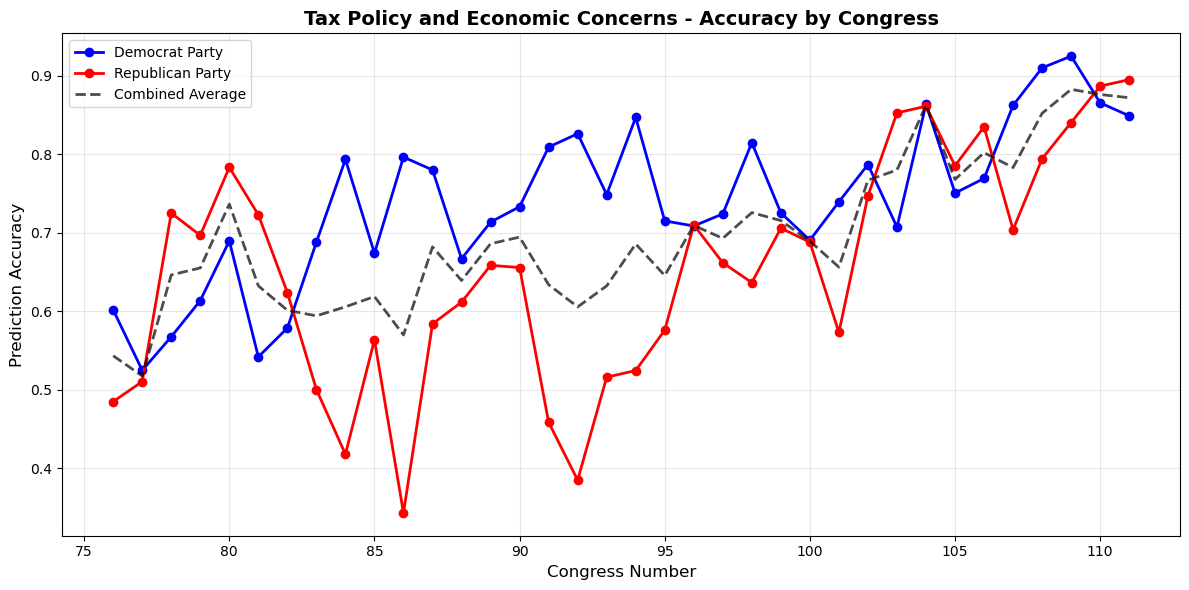

✓ Line plot created successfully!


In [16]:
# ============================================================================
# TAX POLICY AND ECONOMIC CONCERNS - DETAILED ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your results (assuming you have the results_df from your previous code)
# If you need to load from CSV:
# results_df = pd.read_csv("topic_accuracy_simple.csv")

# Filter for Tax Policy and Economic Concerns (topic 17)
tax_policy_data = results_df[results_df['topic_name'] == 'Tax Policy and Economic Concerns'].copy()

print("TAX POLICY AND ECONOMIC CONCERNS - CONGRESS-BY-CONGRESS ANALYSIS")
print("="*70)

if len(tax_policy_data) == 0:
    print("No data found for 'Tax Policy and Economic Concerns'")
    print("Available topics:")
    print(results_df['topic_name'].unique())
else:
    # Sort by congress number
    tax_policy_data = tax_policy_data.sort_values('congress_num')
    
    print(f"Topic Number: {tax_policy_data['topic_number'].iloc[0]}")
    print(f"Topic Name: {tax_policy_data['topic_name'].iloc[0]}")
    print(f"Congress Range: {tax_policy_data['congress_num'].min()} - {tax_policy_data['congress_num'].max()}")
    print(f"Total Congresses: {tax_policy_data['congress_num'].nunique()}")
    
    print(f"\nDETAILED BREAKDOWN BY CONGRESS:")
    print("-" * 70)
    
    # Create summary table
    for _, row in tax_policy_data.iterrows():
        congress = int(row['congress_num'])
        party = row['party']
        accuracy = row['accuracy']
        frequency = row['frequency']
        
        print(f"Congress {congress:3d} | Party: {party} | Accuracy: {accuracy:.3f} | Speeches: {frequency:4d}")
    
    # Calculate statistics by congress (combining R and D)
    print(f"\nCOMBINED STATISTICS BY CONGRESS:")
    print("-" * 50)
    
    congress_summary = []
    for congress in sorted(tax_policy_data['congress_num'].unique()):
        congress_data = tax_policy_data[tax_policy_data['congress_num'] == congress]
        
        mean_accuracy = congress_data['accuracy'].mean()
        total_speeches = congress_data['frequency'].sum()
        num_parties = len(congress_data)
        
        # Find which parties are present
        parties = ', '.join(sorted(congress_data['party'].tolist()))
        
        congress_summary.append({
            'congress_num': congress,
            'mean_accuracy': mean_accuracy,
            'total_speeches': total_speeches,
            'parties': parties,
            'num_parties': num_parties
        })
        
        print(f"Congress {congress:3d}: Avg Accuracy = {mean_accuracy:.3f}, Total Speeches = {total_speeches:4d}, Parties = {parties}")
    
    # Overall statistics
    print(f"\nOVERALL STATISTICS:")
    print("-" * 30)
    print(f"Average Accuracy (all): {tax_policy_data['accuracy'].mean():.3f}")
    print(f"Standard Deviation: {tax_policy_data['accuracy'].std():.3f}")
    print(f"Minimum Accuracy: {tax_policy_data['accuracy'].min():.3f} (Congress {tax_policy_data.loc[tax_policy_data['accuracy'].idxmin(), 'congress_num']:.0f})")
    print(f"Maximum Accuracy: {tax_policy_data['accuracy'].max():.3f} (Congress {tax_policy_data.loc[tax_policy_data['accuracy'].idxmax(), 'congress_num']:.0f})")
    print(f"Total Speeches: {tax_policy_data['frequency'].sum()}")
    
    # Party-specific analysis
    print(f"\nPARTY-SPECIFIC ANALYSIS:")
    print("-" * 30)
    
    party_stats = tax_policy_data.groupby('party').agg({
        'accuracy': ['mean', 'std', 'min', 'max', 'count'],
        'frequency': 'sum'
    }).round(3)
    
    party_stats.columns = ['mean_accuracy', 'std_accuracy', 'min_accuracy', 'max_accuracy', 'num_congresses', 'total_speeches']
    print(party_stats)
    
    # Trend analysis
    print(f"\nTREND ANALYSIS:")
    print("-" * 20)
    
    # Calculate trend over time
    congress_nums = sorted(tax_policy_data['congress_num'].unique())
    congress_means = [tax_policy_data[tax_policy_data['congress_num'] == c]['accuracy'].mean() 
                     for c in congress_nums]
    
    if len(congress_nums) > 1:
        # Simple linear trend
        x = np.arange(len(congress_nums))
        slope = np.polyfit(x, congress_means, 1)[0]
        
        print(f"Linear trend slope: {slope:.6f}")
        if slope > 0:
            print("Trend: INCREASING polarization over time")
        else:
            print("Trend: DECREASING polarization over time")
    
    # Find most/least polarized periods
    congress_summary_df = pd.DataFrame(congress_summary)
    most_polarized = congress_summary_df.loc[congress_summary_df['mean_accuracy'].idxmax()]
    least_polarized = congress_summary_df.loc[congress_summary_df['mean_accuracy'].idxmin()]
    
    print(f"\nMost polarized period: Congress {most_polarized['congress_num']:.0f} (accuracy: {most_polarized['mean_accuracy']:.3f})")
    print(f"Least polarized period: Congress {least_polarized['congress_num']:.0f} (accuracy: {least_polarized['mean_accuracy']:.3f})")
    
    # Create line plot
    print(f"\nCREATING VISUALIZATION...")
    print("-" * 25)
    
    plt.figure(figsize=(12, 6))
    
    # Plot separate lines for R and D with party colors
    party_colors = {'R': 'red', 'D': 'blue'}
    party_names = {'R': 'Republican', 'D': 'Democrat'}
    
    for party in sorted(tax_policy_data['party'].unique()):
        party_data = tax_policy_data[tax_policy_data['party'] == party]
        plt.plot(party_data['congress_num'], party_data['accuracy'], 
                color=party_colors[party], marker='o', linewidth=2, markersize=6, 
                label=f'{party_names[party]} Party')
    
    # Plot combined average line
    congress_summary_df = pd.DataFrame(congress_summary)
    plt.plot(congress_summary_df['congress_num'], congress_summary_df['mean_accuracy'], 
            'k--', linewidth=2, alpha=0.7, label='Combined Average')
    
    plt.title('Tax Policy and Economic Concerns - Accuracy by Congress', fontsize=14, fontweight='bold')
    plt.xlabel('Congress Number', fontsize=12)
    plt.ylabel('Prediction Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✓ Line plot created successfully!")

TAX POLICY AND ECONOMIC CONCERNS - CONGRESS-BY-CONGRESS ANALYSIS
Topic Number: 17
Topic Name: Tax Policy and Economic Concerns
Congress Range: 76 - 111
Total Congresses: 36

DETAILED BREAKDOWN BY CONGRESS:
----------------------------------------------------------------------
Congress  76 | Party: R | Accuracy: 0.485 | Speeches:  392
Congress  76 | Party: D | Accuracy: 0.602 | Speeches:  266
Congress  77 | Party: R | Accuracy: 0.510 | Speeches:  294
Congress  77 | Party: D | Accuracy: 0.524 | Speeches:  286
Congress  78 | Party: R | Accuracy: 0.725 | Speeches:  378
Congress  78 | Party: D | Accuracy: 0.567 | Speeches:  208
Congress  79 | Party: R | Accuracy: 0.697 | Speeches:  145
Congress  79 | Party: D | Accuracy: 0.613 | Speeches:  119
Congress  80 | Party: R | Accuracy: 0.783 | Speeches:  143
Congress  80 | Party: D | Accuracy: 0.689 | Speeches:  161
Congress  81 | Party: R | Accuracy: 0.723 | Speeches:  119
Congress  81 | Party: D | Accuracy: 0.542 | Speeches:  120
Congress  82 | 

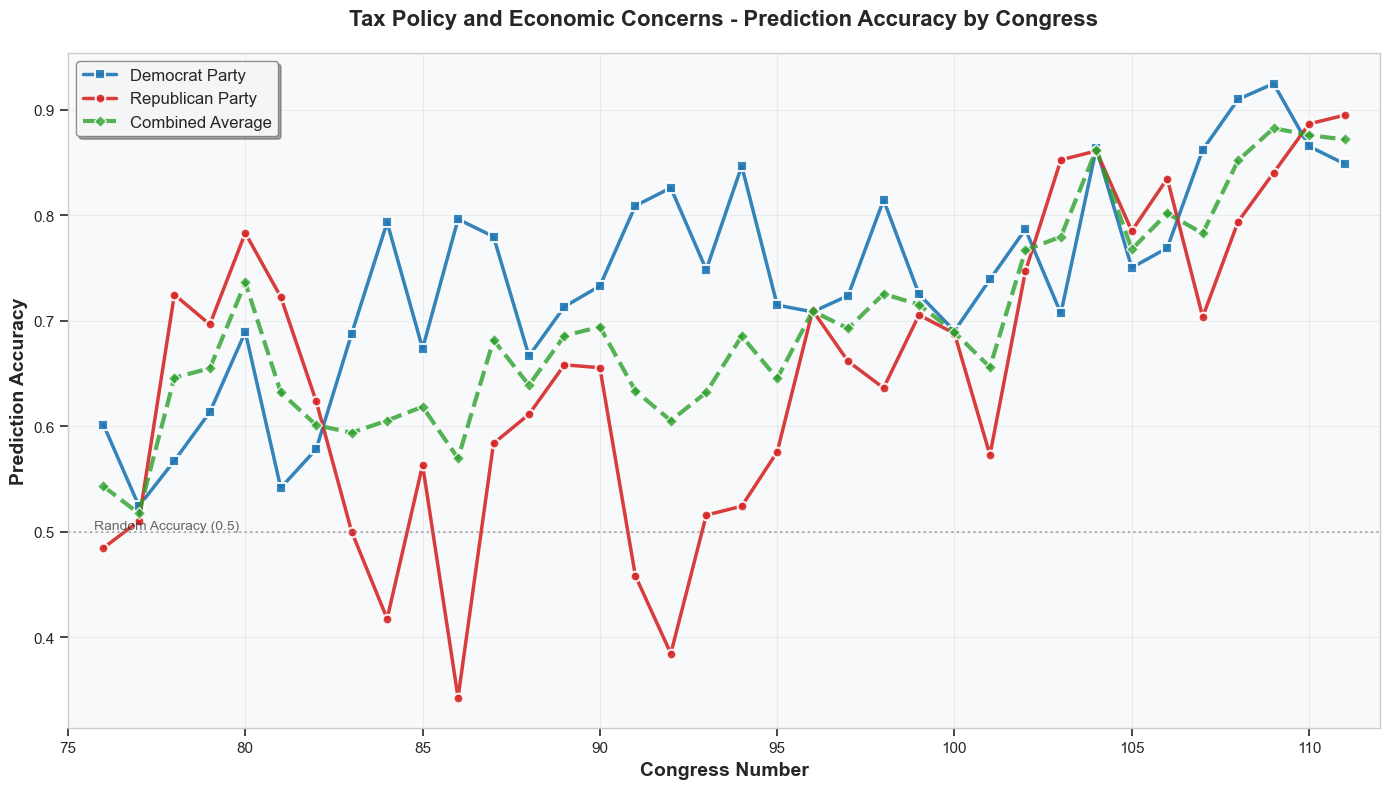

✓ Line plot created successfully!


In [17]:
# ============================================================================
# TAX POLICY AND ECONOMIC CONCERNS - DETAILED ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your results (assuming you have the results_df from your previous code)
# If you need to load from CSV:
# results_df = pd.read_csv("topic_accuracy_simple.csv")

# Filter for Tax Policy and Economic Concerns (topic 17)
tax_policy_data = results_df[results_df['topic_name'] == 'Tax Policy and Economic Concerns'].copy()

print("TAX POLICY AND ECONOMIC CONCERNS - CONGRESS-BY-CONGRESS ANALYSIS")
print("="*70)

if len(tax_policy_data) == 0:
    print("No data found for 'Tax Policy and Economic Concerns'")
    print("Available topics:")
    print(results_df['topic_name'].unique())
else:
    # Sort by congress number
    tax_policy_data = tax_policy_data.sort_values('congress_num')
    
    print(f"Topic Number: {tax_policy_data['topic_number'].iloc[0]}")
    print(f"Topic Name: {tax_policy_data['topic_name'].iloc[0]}")
    print(f"Congress Range: {tax_policy_data['congress_num'].min()} - {tax_policy_data['congress_num'].max()}")
    print(f"Total Congresses: {tax_policy_data['congress_num'].nunique()}")
    
    print(f"\nDETAILED BREAKDOWN BY CONGRESS:")
    print("-" * 70)
    
    # Create summary table
    for _, row in tax_policy_data.iterrows():
        congress = int(row['congress_num'])
        party = row['party']
        accuracy = row['accuracy']
        frequency = row['frequency']
        
        print(f"Congress {congress:3d} | Party: {party} | Accuracy: {accuracy:.3f} | Speeches: {frequency:4d}")
    
    # Calculate statistics by congress (combining R and D)
    print(f"\nCOMBINED STATISTICS BY CONGRESS:")
    print("-" * 50)
    
    congress_summary = []
    for congress in sorted(tax_policy_data['congress_num'].unique()):
        congress_data = tax_policy_data[tax_policy_data['congress_num'] == congress]
        
        mean_accuracy = congress_data['accuracy'].mean()
        total_speeches = congress_data['frequency'].sum()
        num_parties = len(congress_data)
        
        # Find which parties are present
        parties = ', '.join(sorted(congress_data['party'].tolist()))
        
        congress_summary.append({
            'congress_num': congress,
            'mean_accuracy': mean_accuracy,
            'total_speeches': total_speeches,
            'parties': parties,
            'num_parties': num_parties
        })
        
        print(f"Congress {congress:3d}: Avg Accuracy = {mean_accuracy:.3f}, Total Speeches = {total_speeches:4d}, Parties = {parties}")
    
    # Overall statistics
    print(f"\nOVERALL STATISTICS:")
    print("-" * 30)
    print(f"Average Accuracy (all): {tax_policy_data['accuracy'].mean():.3f}")
    print(f"Standard Deviation: {tax_policy_data['accuracy'].std():.3f}")
    print(f"Minimum Accuracy: {tax_policy_data['accuracy'].min():.3f} (Congress {tax_policy_data.loc[tax_policy_data['accuracy'].idxmin(), 'congress_num']:.0f})")
    print(f"Maximum Accuracy: {tax_policy_data['accuracy'].max():.3f} (Congress {tax_policy_data.loc[tax_policy_data['accuracy'].idxmax(), 'congress_num']:.0f})")
    print(f"Total Speeches: {tax_policy_data['frequency'].sum()}")
    
    # Party-specific analysis
    print(f"\nPARTY-SPECIFIC ANALYSIS:")
    print("-" * 30)
    
    party_stats = tax_policy_data.groupby('party').agg({
        'accuracy': ['mean', 'std', 'min', 'max', 'count'],
        'frequency': 'sum'
    }).round(3)
    
    party_stats.columns = ['mean_accuracy', 'std_accuracy', 'min_accuracy', 'max_accuracy', 'num_congresses', 'total_speeches']
    print(party_stats)
    
    # Trend analysis
    print(f"\nTREND ANALYSIS:")
    print("-" * 20)
    
    # Calculate trend over time
    congress_nums = sorted(tax_policy_data['congress_num'].unique())
    congress_means = [tax_policy_data[tax_policy_data['congress_num'] == c]['accuracy'].mean() 
                     for c in congress_nums]
    
    if len(congress_nums) > 1:
        # Simple linear trend
        x = np.arange(len(congress_nums))
        slope = np.polyfit(x, congress_means, 1)[0]
        
        print(f"Linear trend slope: {slope:.6f}")
        if slope > 0:
            print("Trend: INCREASING polarization over time")
        else:
            print("Trend: DECREASING polarization over time")
    
    # Find most/least polarized periods
    congress_summary_df = pd.DataFrame(congress_summary)
    most_polarized = congress_summary_df.loc[congress_summary_df['mean_accuracy'].idxmax()]
    least_polarized = congress_summary_df.loc[congress_summary_df['mean_accuracy'].idxmin()]
    
    print(f"\nMost polarized period: Congress {most_polarized['congress_num']:.0f} (accuracy: {most_polarized['mean_accuracy']:.3f})")
    print(f"Least polarized period: Congress {least_polarized['congress_num']:.0f} (accuracy: {least_polarized['mean_accuracy']:.3f})")
    
    # Create fancy line plot
    print(f"\nCREATING VISUALIZATION...")
    print("-" * 25)
    
    # Set style and create figure
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors and markers in the style of your reference plot
    party_styles = {
        'R': {'color': '#d62728', 'marker': 'o', 'linestyle': '-', 'linewidth': 2.5, 'markersize': 7},
        'D': {'color': '#1f77b4', 'marker': 's', 'linestyle': '-', 'linewidth': 2.5, 'markersize': 7}
    }
    party_names = {'R': 'Republican Party', 'D': 'Democrat Party'}
    
    # Plot separate lines for R and D with enhanced styling
    for party in sorted(tax_policy_data['party'].unique()):
        party_data = tax_policy_data[tax_policy_data['party'] == party]
        style = party_styles[party]
        ax.plot(party_data['congress_num'], party_data['accuracy'], 
                color=style['color'], marker=style['marker'], 
                linestyle=style['linestyle'], linewidth=style['linewidth'], 
                markersize=style['markersize'], label=party_names[party],
                markerfacecolor=style['color'], markeredgecolor='white', 
                markeredgewidth=1.5, alpha=0.9)
    
    # Plot combined average line with different style
    congress_summary_df = pd.DataFrame(congress_summary)
    ax.plot(congress_summary_df['congress_num'], congress_summary_df['mean_accuracy'], 
            color='#2ca02c', linestyle='--', linewidth=3, alpha=0.8, 
            marker='D', markersize=6, label='Combined Average',
            markerfacecolor='#2ca02c', markeredgecolor='white', markeredgewidth=1)
    
    # Enhanced styling
    ax.set_title('Tax Policy and Economic Concerns - Prediction Accuracy by Congress', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Congress Number', fontsize=14, fontweight='semibold')
    ax.set_ylabel('Prediction Accuracy', fontsize=14, fontweight='semibold')
    
    # Customize grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Enhanced legend
    legend = ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, 
                      fontsize=12, framealpha=0.9)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    
    # Set axis limits and ticks
    ax.set_xlim(tax_policy_data['congress_num'].min() - 1, tax_policy_data['congress_num'].max() + 1)
    
    # Add subtle background color
    ax.set_facecolor('#f8f9fa')
    
    # Improve tick styling
    ax.tick_params(axis='both', which='major', labelsize=11, width=1.2, length=6)
    ax.tick_params(axis='both', which='minor', width=0.8, length=4)
    
    # Add horizontal reference line at 0.5 (random accuracy)
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.6, linewidth=1.5)
    ax.text(0.02, 0.5, 'Random Accuracy (0.5)', transform=ax.get_yaxis_transform(), 
            fontsize=10, alpha=0.7, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Line plot created successfully!")